In [1]:
import os
import pandas as pd
import numpy as np
from helpers import VolleyWrapper, aggregate_similarities, aggregate_similarities_all, show_analysed_frames, adjusted_r2
import tqdm
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt

os.chdir('/Users/jniedziela/Developer/master/bpe/')

DATA_DIR = 'attack_pose_data/'
SCORES_DATA = 'attack_pose_data/pose_scores.xlsx'
JSON_DATA_DIR = 'attack_pose_data/json_files/'
EXCEL_DATA_DIR = 'attack_pose_data/excel_files/'

In [13]:
SCORE_COLUMNS = [
    'aanloop_aantal_passen_score', # NUMBER OF STEPS B4 JUMP IF > 2 THEN 1 ELSE 0 (0 or 1)
    'rem_pas_score',  # LAST STEP (0 or 1)
    'sprong_hoek_score', # JUMP ANGLE (0 to 1)
    'positie_tov_bal_score', # POSITION RELATIVE TO BALL (0 or 1)
    'slagarm_hoek_score', # ATTACK ARM ANGLE (0 to 1)
    'totaal_score'
]

scores = pd.read_excel(SCORES_DATA, index_col=0)[['pose_tabel'] + SCORE_COLUMNS]
scores['json_file'] = scores['pose_tabel'].str.replace('.xlsx', '.json')
scores.sample(5)

,pose_tabel,aanloop_aantal_passen_score,rem_pas_score,sprong_hoek_score,positie_tov_bal_score,slagarm_hoek_score,totaal_score,json_file
41,GX010047_Clip_2_POSE_tabel.xlsx,1,1,0.611111,1,0.850000,4.461111,GX010047_Clip_2_POSE_tabel.json
26,GX010045_Clip_5_POSE_tabel.xlsx,1,1,0.522222,0,0.872222,3.394444,GX010045_Clip_5_POSE_tabel.json
15,GX010044_Clip_5_POSE_tabel.xlsx,1,0,0.600000,0,0.877778,2.477778,GX010044_Clip_5_POSE_tabel.json
32,GX010046_Clip_17_POSE_tabel.xlsx,1,1,0.533333,1,0.777778,4.311111,GX010046_Clip_17_POSE_tabel.json
27,GX010045_Clip_7_POSE_tabel.xlsx,1,1,0.544444,0,0.950000,3.494444,GX010045_Clip_7_POSE_tabel.json


In [3]:
best_scored_video = scores.sort_values('totaal_score', ascending=False).iloc[0]
display(best_scored_video)
best_scored_video_file = best_scored_video['json_file']

pose_tabel      GX010044_Clip_6_POSE_tabel.xlsx
totaal_score                                4.5
json_file       GX010044_Clip_6_POSE_tabel.json
Name: 16, dtype: object

In [9]:
AGG_COLS = ['ra_min', 'la_min', 'rl_min', 'll_min', 'torso_min', 'ra_max', 'la_max', 'rl_max', 'll_max', 'torso_max', 'ra_mean', 'la_mean', 'rl_mean', 'll_mean', 'torso_mean', 'ra_std', 'la_std', 'rl_std', 'll_std', 'torso_std']


## Check if there are patterns in coefficients
### Full sequences

In [4]:
search_results = pd.DataFrame(columns=['window', 'stride', 'score', *AGG_COLS])

for window in tqdm.tqdm(range(15, 179, 5)):
    for stride in range(5, 185, 5):

        results_df = pd.DataFrame(columns=['video_1', 'video_2'] + AGG_COLS)

        vid_1_path = JSON_DATA_DIR + best_scored_video_file

        for vid_2 in os.listdir(JSON_DATA_DIR):
            vid_2_path = JSON_DATA_DIR + vid_2
            analyser = VolleyWrapper(vid_1_path, vid_2_path, window, stride)
            sims = analyser.motion_similarity_per_window

            sims_agg = aggregate_similarities_all(sims)

            results_df.loc[len(results_df)] = [
                best_scored_video_file, 
                vid_2, 
                *list(sims_agg.values())
                ]
            
        model_results_df = results_df.merge(scores[['json_file', 'totaal_score']], left_on='video_2', right_on='json_file')

        linear = LinearRegression()
        X = model_results_df[AGG_COLS]
        y = model_results_df['totaal_score']

        linear.fit(X, y)
        score = linear.score(X, y)
        search_results.loc[len(search_results)] = [window, stride, score, *linear.coef_]

        if len(sims) == 1:
            break
    

  0%|          | 0/33 [00:00<?, ?it/s]

100%|██████████| 33/33 [23:01<00:00, 41.86s/it]


<Axes: xlabel='stride', ylabel='window'>

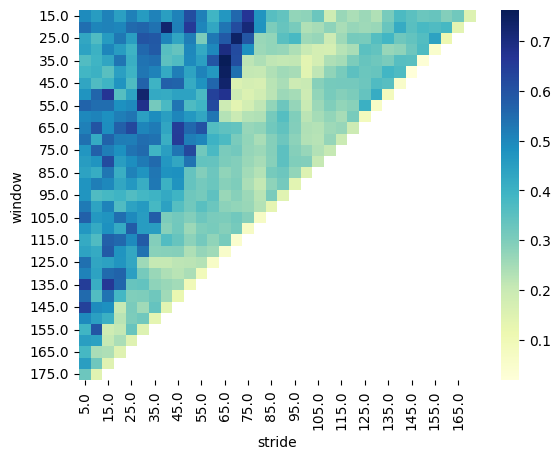

In [5]:
pivot_df = search_results.pivot(index='window', columns='stride', values='score')

# Plot heatmap
sns.heatmap(pivot_df, cmap="YlGnBu")

In [36]:
search_results.sort_values('score', ascending=False).head(10)

,window,stride,score,ra_min,la_min,rl_min,ll_min,torso_min,ra_max,la_max,...,ra_mean,la_mean,rl_mean,ll_mean,torso_mean,ra_std,la_std,rl_std,ll_std,torso_std
142,35.0,65.0,0.761330,14.478978,6.084379,-96.372846,-43.812819,-9.784027,-13.068370,-12.455004,...,2.520731,3.397047,54.894464,-0.764963,8.230685,38.484763,16.823647,-180.233566,-87.953601,-13.427195
172,40.0,65.0,0.747966,6.209534,5.465299,-72.766042,-66.499429,-11.405823,-4.919678,-8.923359,...,-0.742189,4.526702,28.417550,5.936954,7.927067,17.065338,16.924002,-151.155427,-135.282487,-19.641710
80,25.0,70.0,0.740520,12.988166,1.898830,47.007912,57.696075,-8.280480,-10.634900,-6.830099,...,-0.357648,4.881979,-25.701995,-58.400063,12.035549,30.865846,7.803330,81.979253,82.931177,-7.024568
201,45.0,65.0,0.731614,4.320863,-2.079490,-110.826643,-10.830273,-0.623320,-1.674573,0.394242,...,-3.350261,4.661061,5.269756,-35.040573,8.928456,8.486241,-3.101496,-255.980875,-50.376839,7.690912
222,50.0,30.0,0.729369,3.351044,5.118223,4.786970,-30.497589,8.751620,-0.852156,-4.286586,...,-2.838383,0.885166,-12.141827,-30.557267,4.116039,2.230812,19.651020,-5.240912,-94.576294,24.283735
41,20.0,40.0,0.729366,6.082140,4.784188,17.424016,-11.471718,-9.011771,3.231132,-10.333113,...,-8.340375,0.092209,-2.798093,-4.622985,1.991609,8.752014,10.115471,43.030596,-35.765613,-25.009304
48,20.0,75.0,0.710572,4.582073,2.252780,21.813479,41.263655,-2.586096,-2.094629,-12.291328,...,-0.834479,7.565748,-33.395722,6.169937,7.303914,11.617261,10.629504,16.188404,98.681224,2.273390
111,30.0,65.0,0.694615,6.386413,-2.970623,49.640708,128.395565,-2.098603,-1.524775,-0.323722,...,-3.887032,2.838881,-34.768367,-63.866064,4.068591,12.458359,-6.205215,77.734518,233.865198,-1.039340
249,55.0,30.0,0.681551,-1.137461,7.025008,14.103142,-31.308881,15.105729,4.445235,-11.042951,...,-4.279039,7.506930,-2.937795,-44.833373,4.203358,-7.136204,29.673629,24.115565,-112.713510,42.348387
229,50.0,65.0,0.675179,-6.092187,4.373510,-47.568401,-33.906894,8.316862,6.285795,-6.369657,...,-0.072099,4.073944,3.411855,-48.122132,8.696625,-13.160248,13.439526,-109.663170,-107.523957,27.201631


#### Boxplots of coefficient values

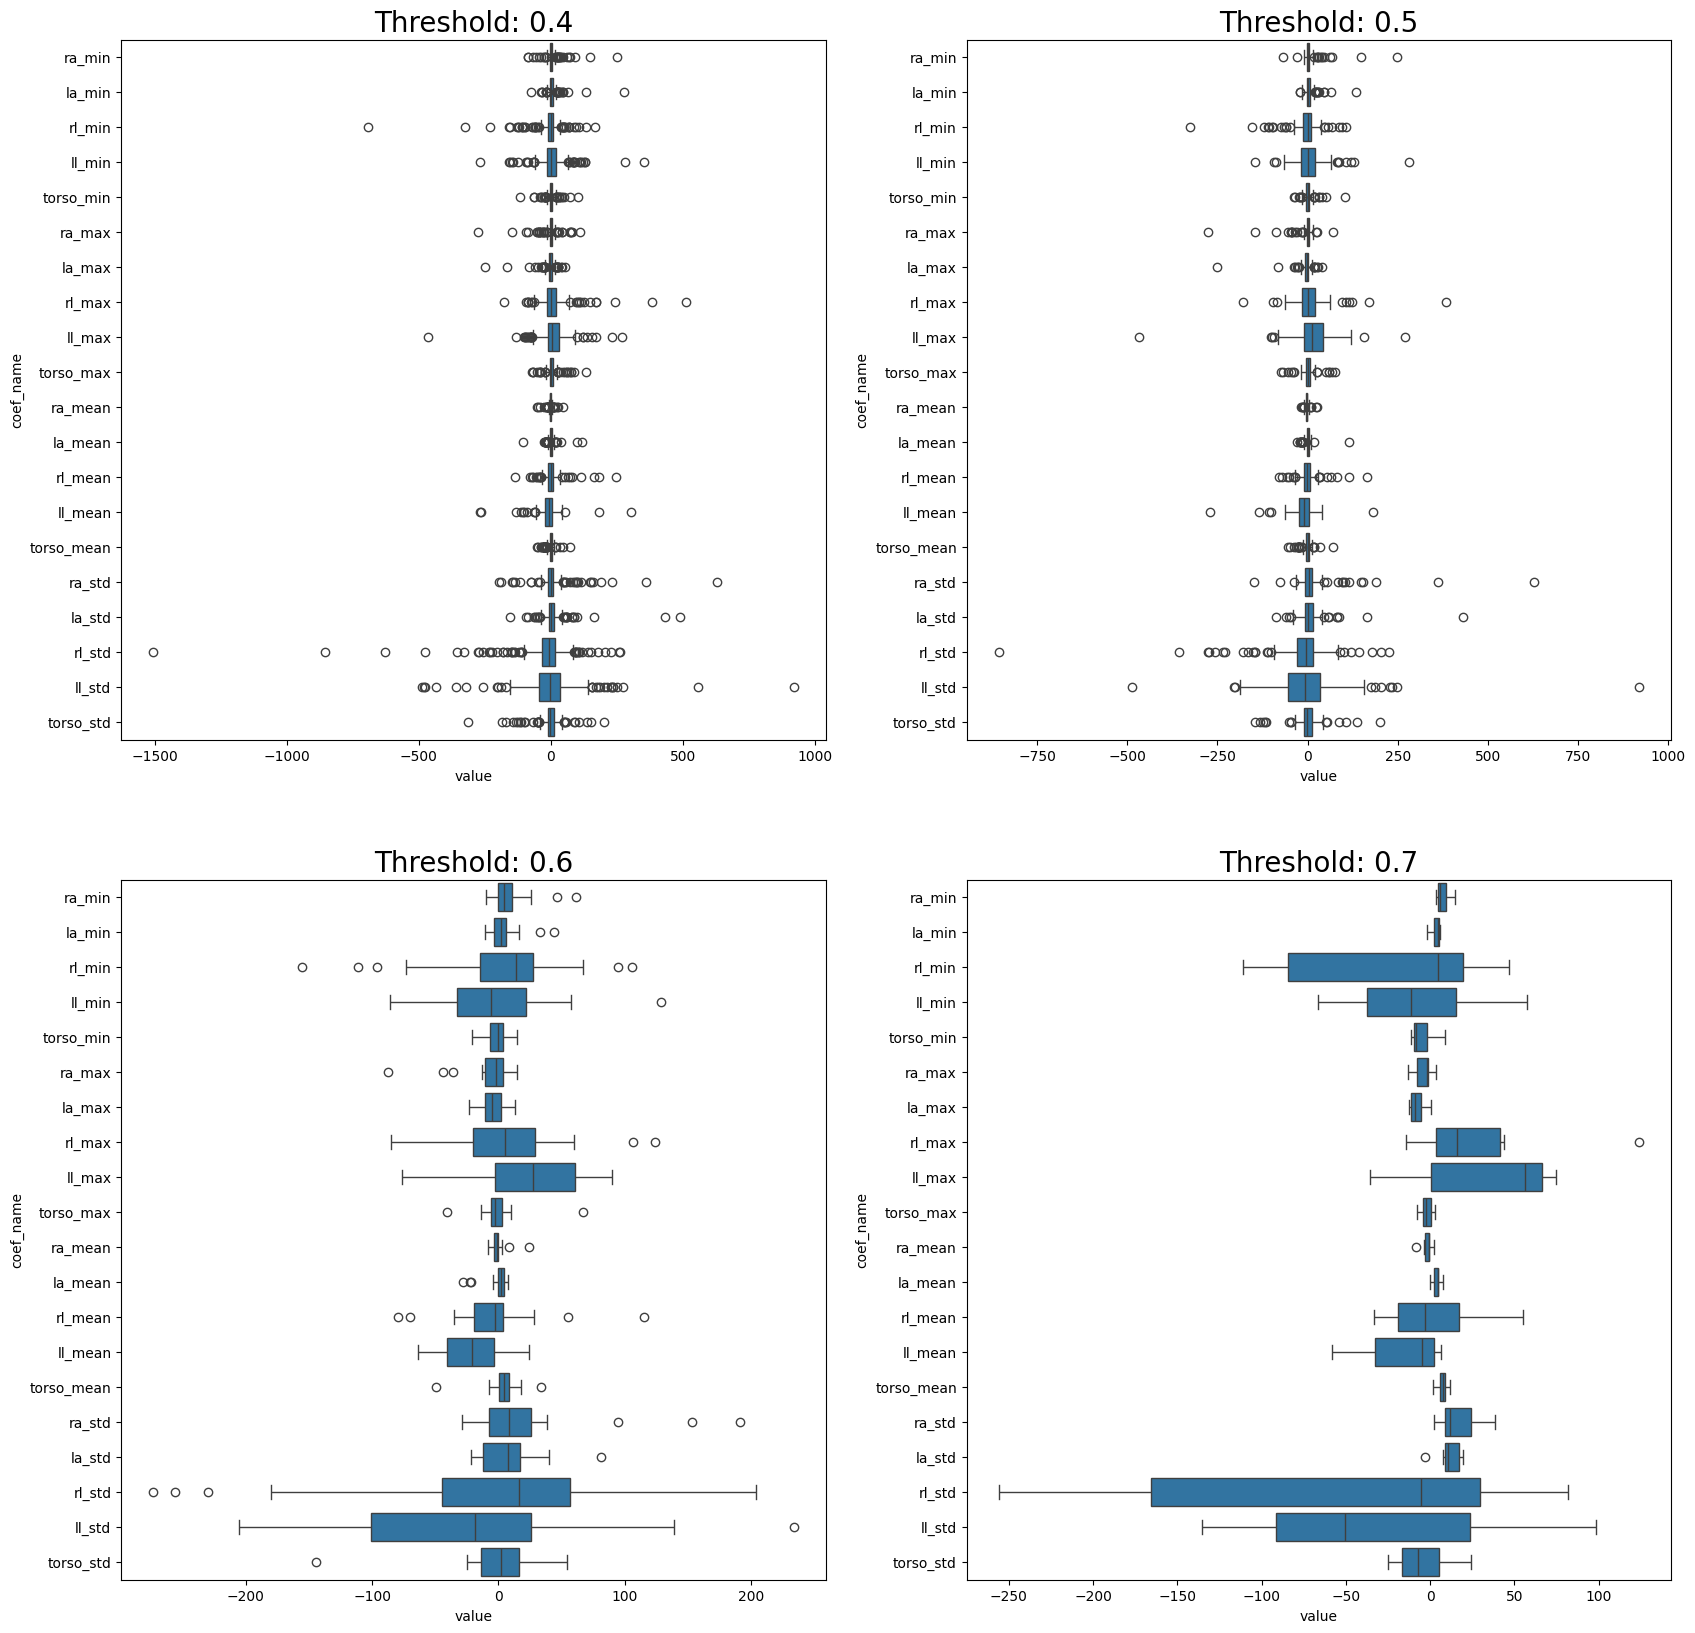

In [44]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20))

for i, thresh in enumerate([0.4, 0.5, 0.6, 0.7]):
    df_melted = pd.melt(
    search_results[(search_results.score > thresh)], 
    id_vars=['window', 'stride', 'score'], 
    value_vars=AGG_COLS, 
    var_name='coef_name', 
    value_name='value'
    )

# Use seaborn to create the boxplot
    sns.boxplot(y='coef_name', x='value', data=df_melted, ax=ax[i//2, i%2])
    ax[i//2, i%2].set_title(f'Threshold: {thresh}', fontsize=20)

#### Correlation of coefficient values with different window sizes

<Axes: >

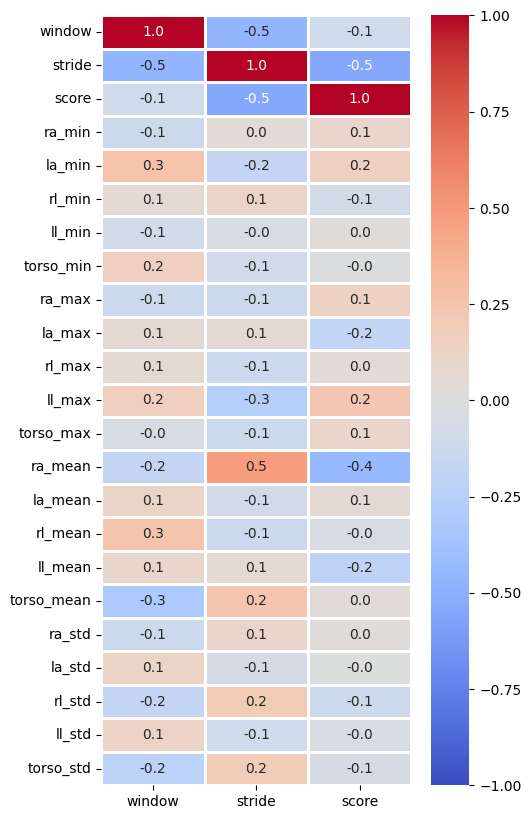

In [68]:
fig = plt.figure(figsize=(5, 10))

sns.heatmap(search_results.corr(method='spearman')[['window', 'stride', 'score']], linewidths=2, annot=True, fmt=".1f", cmap="coolwarm", vmin=-1, vmax=1)

### Attack sequences

In [4]:
# get frame in which attack happens (ball hit)
attack_frames = {}
for file in os.listdir(EXCEL_DATA_DIR):
    df = pd.read_excel(EXCEL_DATA_DIR + file)
    attack_frames[file.replace('.xlsx', '.json')] = df[df.phase == 'attack'][1:-1].Frame.iloc[0]

In [18]:
best_scored_video = scores.sort_values('slagarm_hoek_score', ascending=False).iloc[0]
display(best_scored_video)
best_scored_video_file = best_scored_video['json_file']

pose_tabel                     GX010046_Clip_21_POSE_tabel.xlsx
aanloop_aantal_passen_score                                   1
rem_pas_score                                                 1
sprong_hoek_score                                      0.477778
positie_tov_bal_score                                         0
slagarm_hoek_score                                     0.961111
totaal_score                                           3.438889
json_file                      GX010046_Clip_21_POSE_tabel.json
Name: 34, dtype: object

In [19]:
def window_stride_grid_search_attack(window_range, stride_range, cols_to_use, y_col, num_frames):
    '''
    Function to perform grid search over window and stride values for similarity analysis.
    
    Parameters:
    window_range (range): range of window sizes to test
    stride_range (range): range of stride sizes to test
    cols_to_use (list): list of columns to use in the model as features
    y_col (str): name of the column to use as target variable
    num_frames (int): number of frames to use in the analysis (centered around the attack frame)
    
    Returns:
    search_results (DataFrame): DataFrame with results of the grid search
    '''
    AGG_COLS = ['ra_min', 'la_min', 'rl_min', 'll_min', 'torso_min', 'ra_max', 'la_max', 'rl_max', 'll_max', 'torso_max', 'ra_mean', 'la_mean', 'rl_mean', 'll_mean', 'torso_mean', 'ra_std', 'la_std', 'rl_std', 'll_std', 'torso_std']
    search_results = pd.DataFrame(columns=['window', 'stride', 'score', 'adj_r2', *AGG_COLS])

    for window in tqdm.tqdm(window_range):
        for stride in stride_range:

            results_df = pd.DataFrame(columns=['video_1', 'video_2'] + AGG_COLS)

            vid_1_path = JSON_DATA_DIR + best_scored_video_file

            for vid_2 in os.listdir(JSON_DATA_DIR):
                vid_2_path = JSON_DATA_DIR + vid_2
                analyser = VolleyWrapper(vid_1_path, vid_2_path, window, stride)

                s1_attack = attack_frames[analyser.args.vid1_json_dir.split('/')[-1]]
                analyser.seq1 = analyser.seq1[:, :, s1_attack - num_frames // 2: s1_attack + num_frames // 2]

                s2_attack = attack_frames[analyser.args.vid2_json_dir.split('/')[-1]]
                analyser.seq2 = analyser.seq2[:, :, s2_attack - num_frames // 2 : s2_attack + num_frames // 2]

                analyser._update_similarities()

                sims = analyser.motion_similarity_per_window

                sims_agg = aggregate_similarities_all(sims)

                results_df.loc[len(results_df)] = [
                    best_scored_video_file, 
                    vid_2, 
                    *list(sims_agg.values())
                    ]
                
            model_results_df = results_df.merge(scores[['json_file', y_col]], left_on='video_2', right_on='json_file')

            linear = LinearRegression()
            X = model_results_df[cols_to_use]
            y = model_results_df[y_col]

            linear.fit(X, y)
            score = linear.score(X, y)
            adj_r2 = adjusted_r2(score, len(y), len(X.columns))
            search_results.loc[len(search_results)] = [window, stride, score, adj_r2, *linear.coef_]

            if len(sims) == 1:
                break

    return search_results
    

100%|██████████| 10/10 [04:23<00:00, 26.32s/it]


Text(0.5, 1.0, 'Adjusted R2 heatmap')

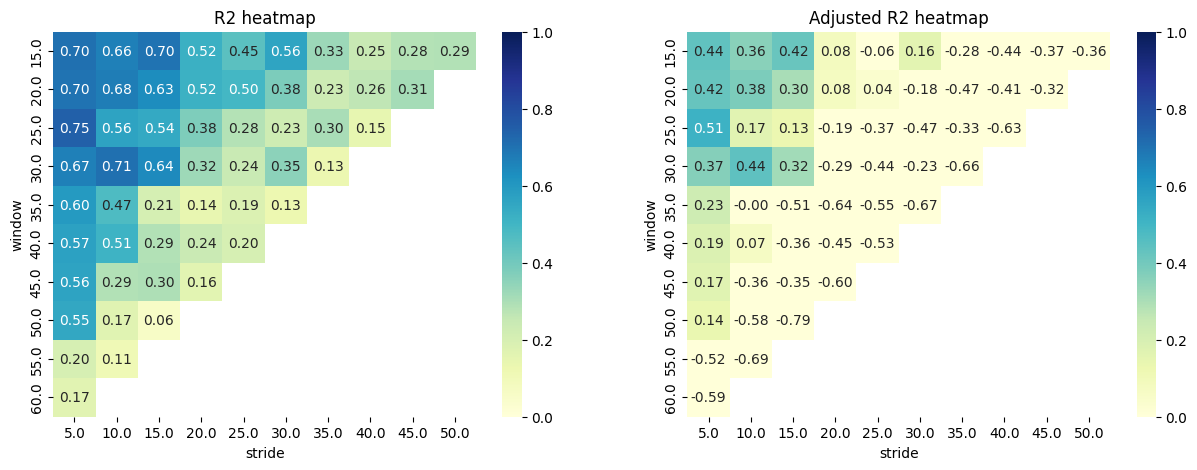

In [20]:
res = window_stride_grid_search_attack(range(15, 65, 5), range(5, 65, 5), AGG_COLS, 'slagarm_hoek_score', 60)

pivot_df1 = res.pivot(index='window', columns='stride', values='score')
pivot_df2 = res.pivot(index='window', columns='stride', values='adj_r2')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Plot heatmap
sns.heatmap(pivot_df1, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[0], annot=True, fmt=".2f")
ax[0].set_title('R2 heatmap')

sns.heatmap(pivot_df2, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[1], annot=True, fmt=".2f")
ax[1].set_title('Adjusted R2 heatmap')

In [21]:
res.sort_values('score', ascending=False).head(10)

,window,stride,score,adj_r2,ra_min,la_min,rl_min,ll_min,torso_min,ra_max,...,ra_mean,la_mean,rl_mean,ll_mean,torso_mean,ra_std,la_std,rl_std,ll_std,torso_std
19,25.0,5.0,0.745553,0.514238,-0.179069,0.208171,1.375009,-2.451863,-0.142374,-0.363327,...,0.471559,-0.534640,-0.132629,-4.476854,0.491961,0.023466,0.049001,2.678249,-12.184278,0.640434
28,30.0,10.0,0.705767,0.438283,0.067926,0.031800,0.403733,-0.199350,0.184117,0.208905,...,-0.036716,-0.409534,0.054930,2.176138,-1.838591,0.168338,-0.352047,0.558334,2.316922,-1.023964
0,15.0,5.0,0.704606,0.436067,0.218549,-0.179549,0.118313,-0.726995,-0.170673,-0.348717,...,0.464031,-0.407592,-0.597630,-0.998426,0.508361,1.144179,-0.829235,-0.556402,-3.661126,0.255070
10,20.0,5.0,0.697572,0.422637,-0.062319,0.017694,1.132003,-0.025693,0.297982,-0.073088,...,0.298749,-0.261746,-0.259842,-1.959037,0.916195,0.159927,-0.306551,2.708277,-1.328279,2.160070
2,15.0,15.0,0.696169,0.419958,-0.573799,0.102083,0.219850,0.884022,-0.508214,0.901929,...,0.047528,-0.344417,1.917348,-3.456005,0.012167,-1.508687,0.024722,1.872823,-0.344882,-1.181822
11,20.0,10.0,0.675564,0.380623,-0.009557,-0.013160,-0.637392,-3.661205,-0.609806,-0.243147,...,0.483798,-0.370497,0.619702,-0.249880,-0.543253,0.526909,-0.443710,-1.368867,-10.180272,-1.797977
27,30.0,5.0,0.667454,0.365139,0.444893,0.149896,-0.417661,-0.552248,-0.005440,-0.179978,...,0.009760,-0.572317,0.138578,0.577844,-0.904704,1.409529,-0.284195,-1.526434,-1.043211,-0.473059
1,15.0,10.0,0.664265,0.359051,-0.070991,0.251059,0.002204,4.957184,-0.758308,0.566963,...,0.409417,-0.516326,0.202633,-4.399685,0.728454,0.306245,0.035951,-0.005879,9.517356,-0.579465
29,30.0,15.0,0.641750,0.316068,1.451546,-0.901342,-0.394938,1.225516,-2.877727,-0.809157,...,-0.336774,-0.678946,0.543468,1.630447,-0.608041,3.057562,-2.614834,-0.595047,4.886348,-7.039924
12,20.0,15.0,0.633874,0.301032,-0.498053,-1.140617,1.062254,0.704427,2.268184,-0.077097,...,0.451849,0.635569,0.267863,-2.167848,-2.008645,-0.867576,-2.103176,2.213380,-0.716568,3.689618


#### Boxplots of coefficient values

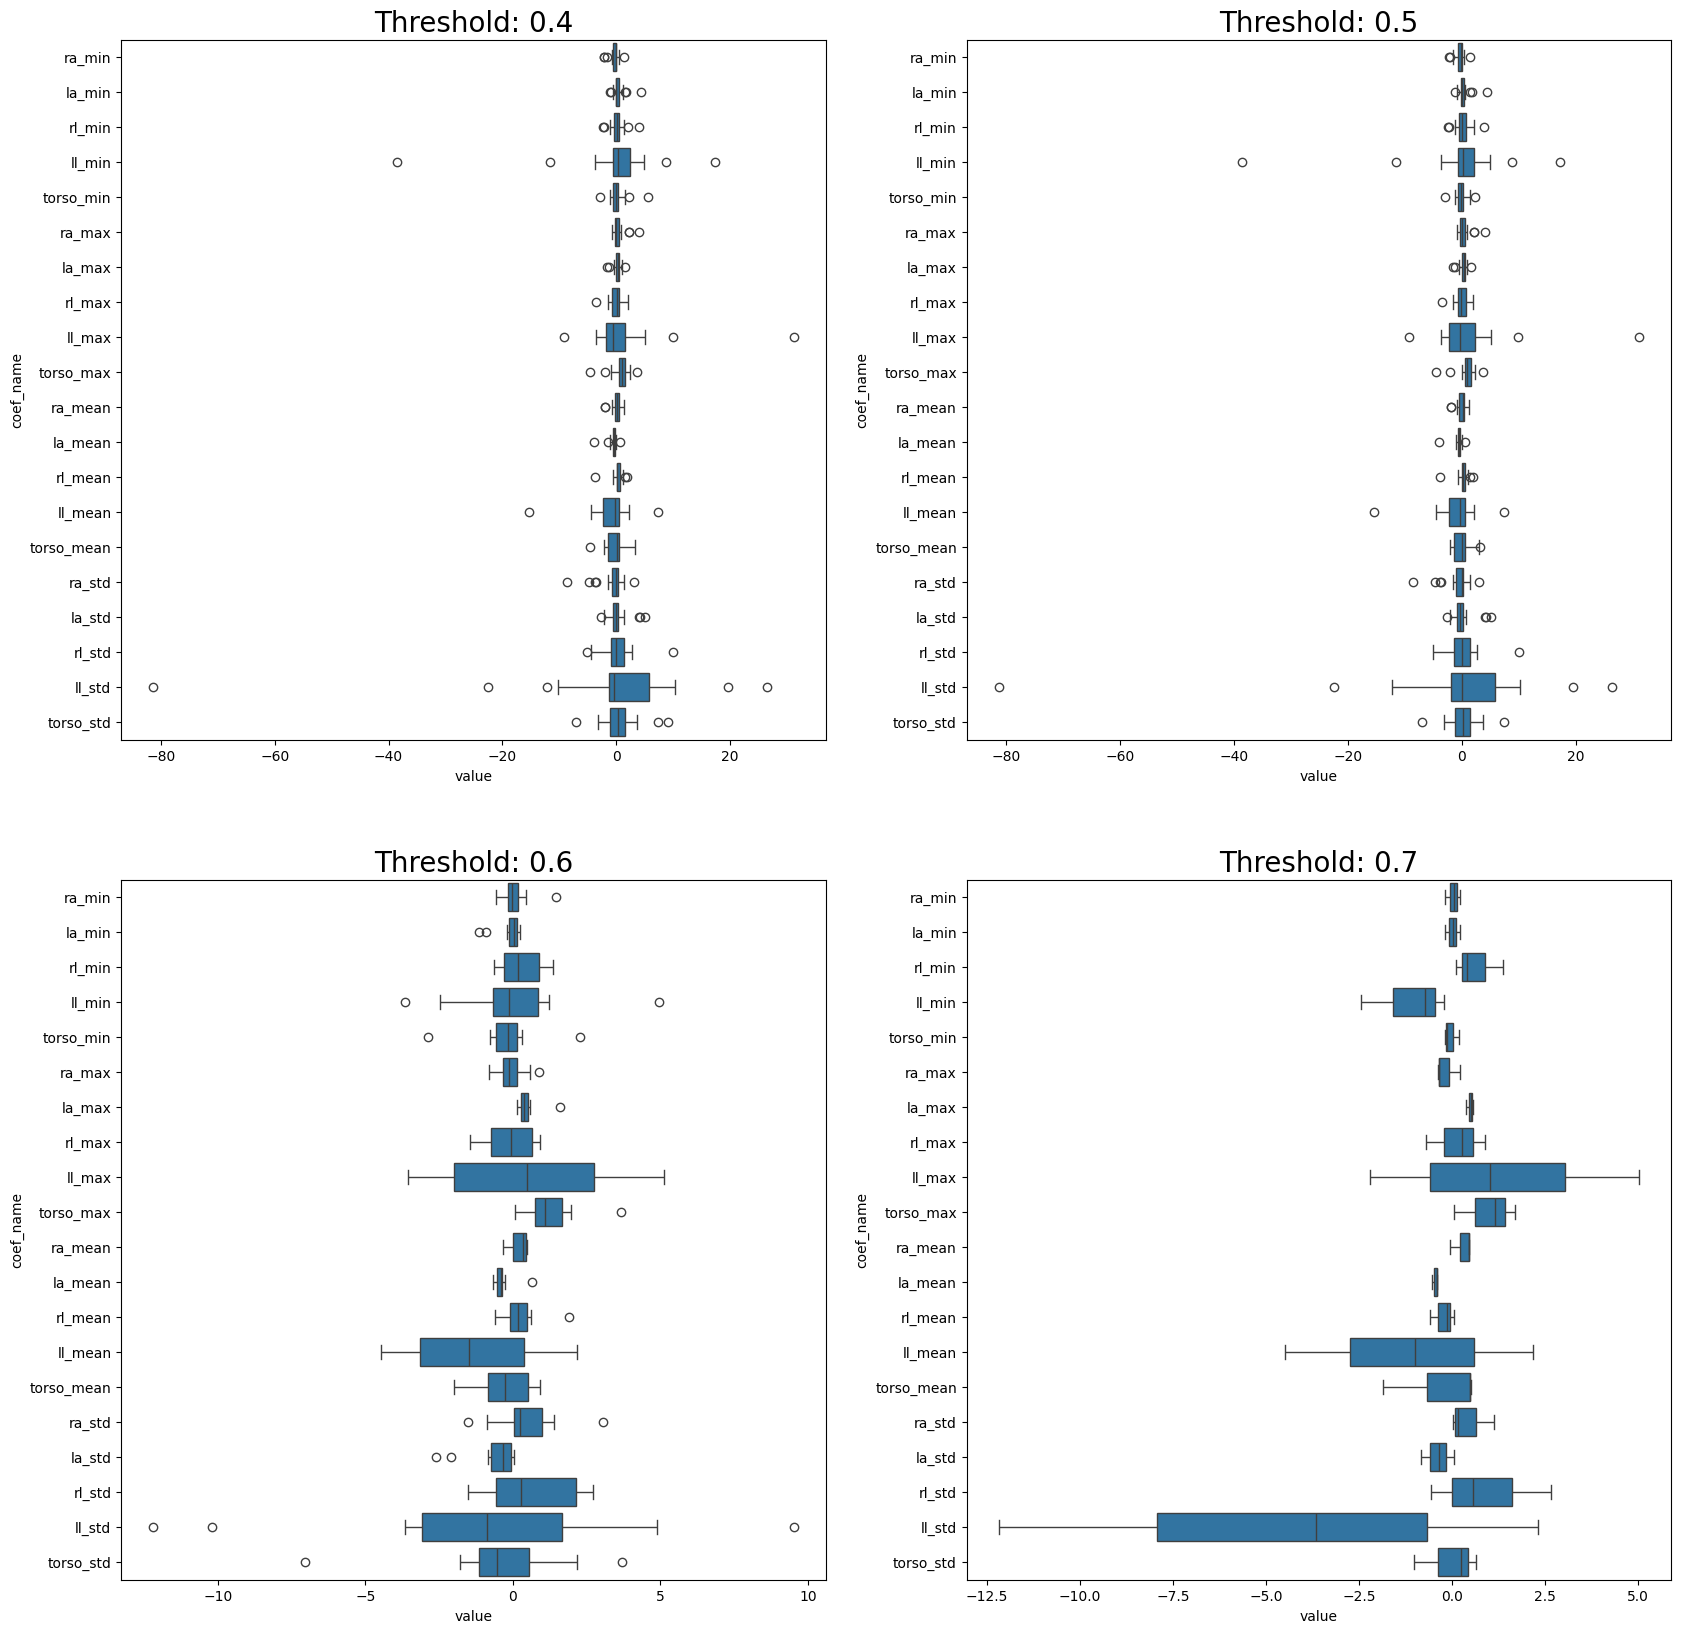

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20))

for i, thresh in enumerate([0.4, 0.5, 0.6, 0.7]):
    df_melted = pd.melt(
    res[(res.score > thresh)], 
    id_vars=['window', 'stride', 'score'], 
    value_vars=AGG_COLS, 
    var_name='coef_name', 
    value_name='value'
    )

# Use seaborn to create the boxplot
    sns.boxplot(y='coef_name', x='value', data=df_melted, ax=ax[i//2, i%2])
    ax[i//2, i%2].set_title(f'Threshold: {thresh}', fontsize=20)

#### Correlation of coefficient values with different window sizes

<Axes: >

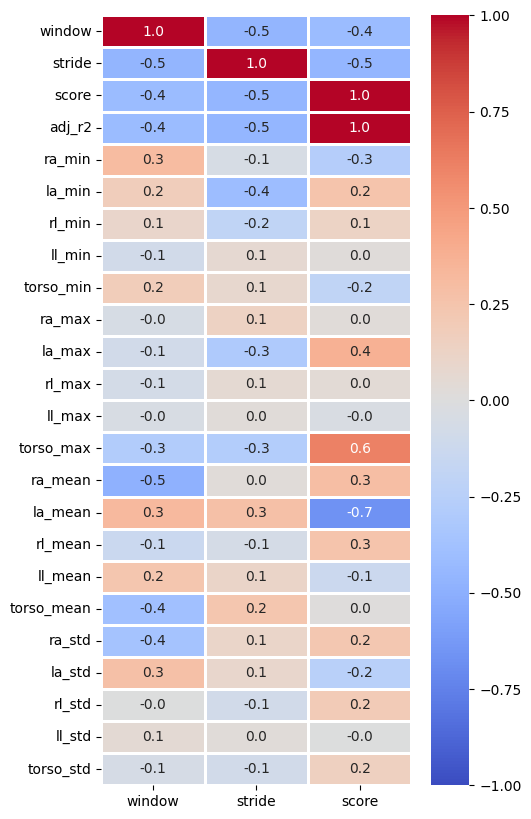

In [23]:
fig = plt.figure(figsize=(5, 10))

sns.heatmap(res.corr(method='spearman')[['window', 'stride', 'score']], linewidths=2, annot=True, fmt=".1f", cmap="coolwarm", vmin=-1, vmax=1)